<a href="https://colab.research.google.com/github/mateuspestana/Deeplearning_Experimentos/blob/main/Aproxima%C3%A7%C3%A3o_de_Cosseno_com_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deeplearning com PyTorch

## Aproximação de Cosseno

#### Bibliotecas utilizadas



In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand
import matplotlib.pyplot as plt
from math import cos

#### Algumas variáveis definidas

In [20]:
interval = (-10, 10) # Intervalo
train_nsamples = 1000 # Número de samples pra treino
test_nsamples = 100 # Número de samples pra teste
epochs = 4000 # Número de epochs para treinar
learning_rate = 1e-3

#### Verificando CUDA


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando em {device}")

Rodando em cuda


#### Gerando um dataset a partir de uma fórmula algébrica

Agora criaremos uma classe chamada `AlgebraicDataset` que criará um dataset a partir de uma fórmula dada. Esse dataset estará pronto pro PyTorch.

In [5]:
class AlgebraicDataset(Dataset):
  # Inicializa a classe com base em self, função, intervalo e número de amostras
  def __init__(self, f, interval, nsamples):
    X = urand.Uniform(interval[0], interval[1]).sample([nsamples])
    self.data = [(x, f(x)) for x in X] # os dados serão dados pela aplicação da fórmula f
  
  # Aqui ele determina o tamanho do dataset
  def __len__(self):
    return len(self.data)
  
  # Aqui ele determina cada item do dataset
  def __getitem__(self, idx):
    return self.data[idx]

#### Funções de treino e teste

Antes de tudo, criaremos também uma função para treinar e para testar a rede que iremos criar.

In [17]:
def train(model, dataloader, lossfunc, optimizer):

  # Determina que o modelo é treinável
  model.train()

  # Zera a soma cumulativa da perda
  cumloss = 0.0

  # Número de batches
  num_batches = len(dataloader)

  # Aqui é um pequeno for no dataloader que redimensiona o dado e joga ele para
  # o mesmo device que o modelo
  # ATENÇÃO: unsqueeze(1).float()
  for X, y in dataloader:
    X = X.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    # Aqui dizemos que a predição é a aplicação do modelo em X e a perda, idem
    pred = model(X)
    loss = lossfunc(pred, y)

    # Como o PyTorch acumula os gradientes, zeramos toda vez que ele passar no For
    optimizer.zero_grad()
    # Calculamos então os gradientes gerados
    loss.backward()
    # Vai em direção ao lado que reduz o erro
    optimizer.step()

    # Como Loss é um tensor, a gente usa o método .item()
    cumloss += loss.item() 
  
  return cumloss / num_batches

# Função de teste
def test(model, dataloader, lossfunc): # Reparar que aqui não temos otimizador. Não há o que otimizar.
  model.eval() # Dizemos aqui que o modelo é um teste, evaluatable
  
  cumloss = 0.0
  num_batches = len(dataloader)
  # Aqui não faremos o gradient descent, não iremos otimizar nada.
  with torch.no_grad():
    for X, y in dataloader:
      X = X.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(X)
      loss = lossfunc(pred, y)
      cumloss += loss.item() 
  
  return cumloss / num_batches

#### A rede neural

Aqui, criamos a classe da rede neural em si:

In [7]:
class MultiLayerNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, 256), # Entra 1, saem 256 neurons
        nn.ReLU(),
        nn.Linear(256, 128), # Entram 256, saem 128
        nn.ReLU(),
        nn.Linear(128, 1), # Entram 128, sai 1
    )

  def forward(self, x):
    return self.layers(x)

#### Plot básico para mostrar o ajuste dos dados

In [15]:
def plot_comparinson(f, model, interval=(-10, 10), nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  ax.grid(True, which='both')
  ax.spines['left'].set_position('zero')
  ax.spines['right'].set_color('none')
  ax.spines['bottom'].set_position('zero')
  ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="Valor real")
  ax.plot(samples, pred.cpu(), label="Modelo")
  plt.legend()
  plt.show()

#### Fórmula e modelo

In [12]:
f = lambda x: cos(x/2)
multimodel = MultiLayerNetwork().to(device)

lossfunc = nn.MSELoss() # Função de Perda: MSE
optimizer = torch.optim.SGD(multimodel.parameters(), lr = learning_rate) # usando Stochastic Gradient Descente como otimizador


#### Dados - Dataloader

Precisamos de uma forma para alimentar os dados ao modelo. Para isso o Dataloader

In [13]:
# Aqui, criamos os datasets
train_dataset = AlgebraicDataset(f, interval, train_nsamples)
test_dataset = AlgebraicDataset(f, interval, test_nsamples)

# Aqui, alimentamos o dataloader com os datasets
train_dataloader = DataLoader(train_dataset, train_nsamples, shuffle = True)
test_dataloader = DataLoader(test_dataset, test_nsamples, shuffle = True)

#### Ao treinamento:

Epoch: 0; Train Loss: 0.007904072292149067


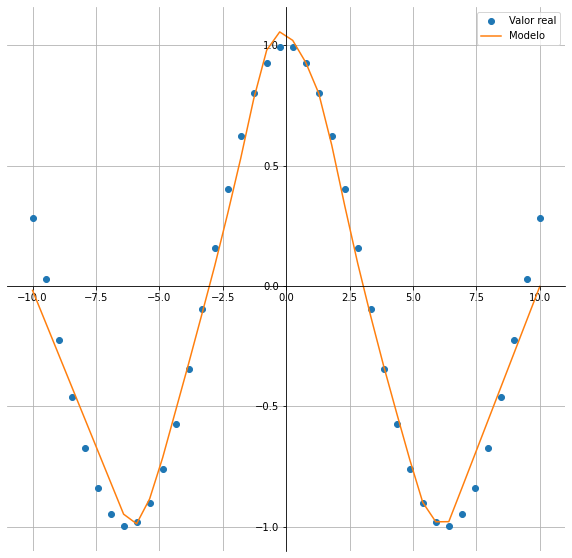

Epoch: 1000; Train Loss: 0.0055924332700669765


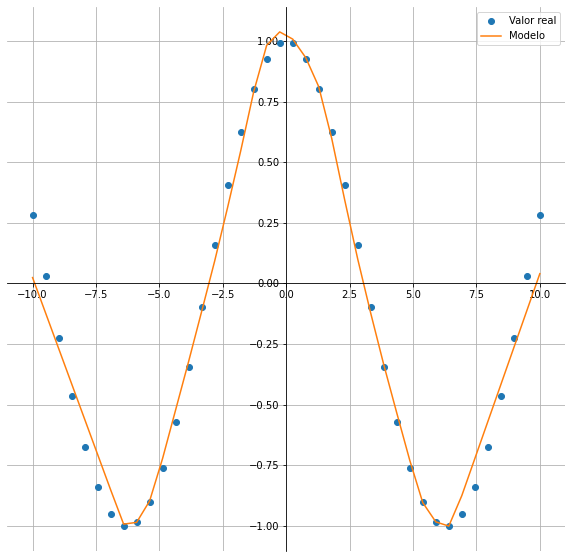

Epoch: 2000; Train Loss: 0.004094749689102173


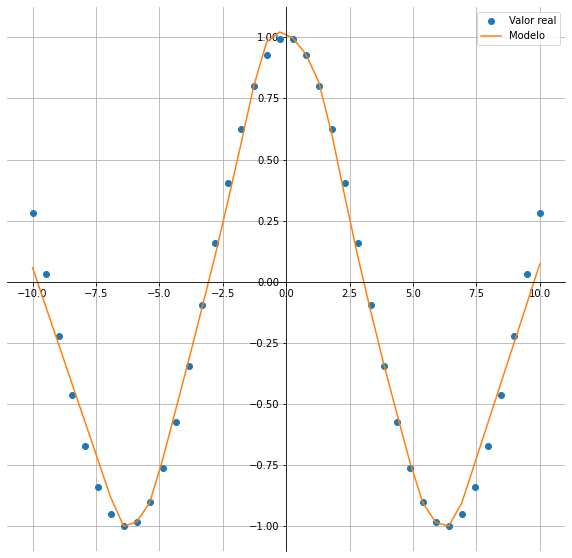

Epoch: 3000; Train Loss: 0.0030834132339805365


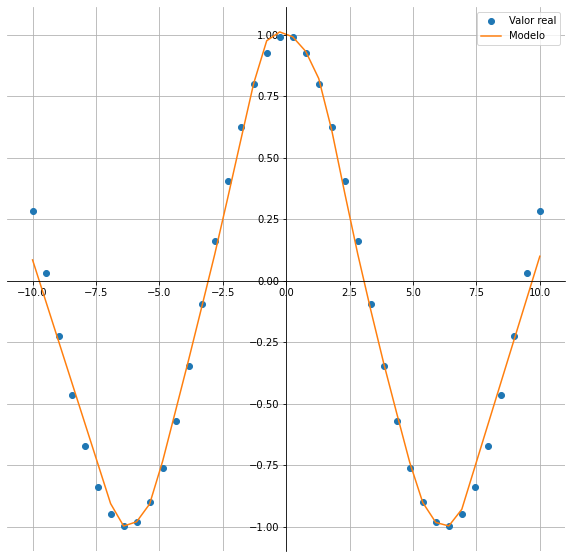

Test Loss: 0.0022388543002307415


In [21]:
for t in range(epochs):
  train_loss = train(multimodel, train_dataloader, lossfunc, optimizer)
  if t % 1000 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    plot_comparinson(f, multimodel, interval,  nsamples=40)

test_loss = test(multimodel, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")